# COCS2673 Assignment 2 P1A - Is or is not cancer prediction

In [1]:
#!pip install tensorflow

In [2]:
#import zipfile
#with zipfile.ZipFile('./Image_classification_data.zip', 'r') as zip_ref:
#   zip_ref.extractall('./')

In [3]:
#!pwd

In [71]:
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping

import IPython.display as display
from PIL import Image
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import datetime

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, precision_recall_fscore_support

tf.__version__


'2.4.1'

# Read Data
Split data into train, validation, and test
Note that images for the same patient may contain a mix of cancerous and non-cancerous data.
Q - Sould we split on patient or just randomly



In [5]:
mainData = pd.read_csv('./data_labels_mainData.csv')
extraData = pd.read_csv('./data_labels_extraData.csv')

In [6]:
mainData.head()

,InstanceID,patientID,ImageName,cellTypeName,cellType,isCancerous
0,22405,1,22405.png,fibroblast,0,0
1,22406,1,22406.png,fibroblast,0,0
2,22407,1,22407.png,fibroblast,0,0
3,22408,1,22408.png,fibroblast,0,0
4,22409,1,22409.png,fibroblast,0,0


In [7]:
extraData.head()

,InstanceID,patientID,ImageName,isCancerous
0,12681,61,12681.png,0
1,12682,61,12682.png,0
2,12683,61,12683.png,0
3,12684,61,12684.png,0
4,12685,61,12685.png,0


# Exploratary Data Analysis (EDA)

In [8]:
print(mainData.dtypes)
print(mainData.shape)
#print(mainData.info())
#print(mainData.describe())


InstanceID       int64
patientID        int64
ImageName       object
cellTypeName    object
cellType         int64
isCancerous      int64
dtype: object
(9896, 6)


In [9]:
print(extraData.dtypes)
print(extraData.shape)
#print(extraData.info())
#print(extraData.describe())

InstanceID      int64
patientID       int64
ImageName      object
isCancerous     int64
dtype: object
(10384, 4)


There are 2 data files mainData with 6 properties and 9896 rows, and extraData with 4 properties and 10384 rows.

For part1, the aim is to predict if a slide is cancerous or not from the image data.
Lets append data and confirm the number of images matches the input data rows.

In [14]:
mainData = mainData.append(extraData, ignore_index=True)
mainData = mainData.sample(2000)   # Sampling used for inital model development

In [15]:
mainData.shape[0]

2000

In [16]:
import glob

image_list = set()
for filepath in glob.glob('./patch_images/*', recursive=True): #assuming gif
    filename = filepath.split("\\")[-1]
    image_list.add(filename)
    
print(len(image_list))

20280


The number of images matches the records.

Update Categorical Data types

In [17]:
mainData['cellType'] = mainData['cellType'].astype('category')
mainData['cellTypeName'] = mainData['cellTypeName'].astype('category')


In [18]:
mainData.isnull().sum()

InstanceID         0
patientID          0
ImageName          0
cellTypeName    1349
cellType        1349
isCancerous        0
dtype: int64

In [19]:
mainData['patientID'].value_counts()

77    84
79    80
91    78
92    71
90    69
      ..
74     1
75     1
27     1
34     1
96     1
Name: patientID, Length: 96, dtype: int64

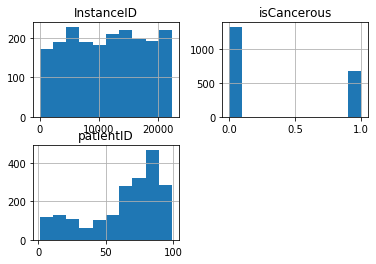

In [20]:
mainData.hist()
plt.show()

In [21]:
# Remove non-relevant data - instance is ID
mainData.drop(['InstanceID'], axis=1,inplace=True)

# cellType and cellTypeName may be not known in scan so for this case removed - identification is part2
# Note this data could be use but it is not as its not in main data set
mainData.drop(['cellType'], axis=1,inplace=True)
mainData.drop(['cellTypeName'], axis=1,inplace=True)

In [22]:
mainData.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2000 entries, 18662 to 2504
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   patientID    2000 non-null   int64 
 1   ImageName    2000 non-null   object
 2   isCancerous  2000 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 62.5+ KB


**There are no missing values in the datasets.**

In [23]:
def BinBreakdown(desc, data):
    neg, pos = np.bincount(data)
    total = neg + pos
    print('{} Class Data:\n    Total: {}\n    Positive: {} ({:.2f}% of total)\n'.format(desc, total, pos, 100 * pos / total))

In [24]:
BinBreakdown('Input Data', mainData.isCancerous)

Input Data Class Data:
    Total: 2000
    Positive: 673 (33.65% of total)



#### Key observations:
* Data has 20280  observations and 6 columns.
* InstanceID - is Id field, need to remove as not information attribute
* cellTypeName, cellType - indicator of actual cell type and not used in this case for cancer diagnosis
* isCancerous - indicator of the actual diagnosis (1 = cancerous, 0 = benign)
* image count matches data rows 

Split of benign to cancerous is a 35% cancerous, 65% benign

* The class value is boolean so doesn't have outliers etc to consider

# Train/Validation/Test Split on Patients

### Add classification class

In [25]:
mainData['isCancerous'] = mainData['isCancerous'].astype('str')

### Split Data into Train/Validate/Test
For test and training data split via person.
This assumes that if a person has cancer or not, then would the images for that person have cancer.
Also different cell types per person would be used for validation/testing.

In [26]:
# Get list of patients and observation counts
# Allocate approc 25% of data for Validation and Testing - of that 60%/40% for validation/test split.
TEST_RATIO = 0.10
VAL_RATIO = 0.15


In [27]:
# Split train tests by ratios
# Select random patients until the number of images for 
# each patient sums to the number of records require

np.random.seed(43) # Consistent random list

recCount = mainData.shape[0]
custRec = mainData.patientID.value_counts().to_dict()
    
patientIds = list(custRec.keys())

# Loop through selecting a patient at random summing the number of images they have
# until the count of images crosses is more than required number

testCust = []
testRecs = 0
while (testRecs < (recCount * TEST_RATIO)):
    pId = np.random.choice(patientIds)
    ic = custRec.get(pId)
    patientIds.remove(pId)
    testCust.append(pId)
    testRecs += ic
    
#print(testCust, testRecs)

valCust = []
valRecs = 0
while (valRecs < (recCount * VAL_RATIO)):
    pId = np.random.choice(patientIds)
    ic = custRec.get(pId)
    patientIds.remove(pId)
    valCust.append(pId)
    valRecs += ic

#print(valCust, valRecs)

In [28]:
testData = mainData[mainData.patientID.isin(testCust)]
valData = mainData[mainData.patientID.isin(valCust)]
trainData = mainData[~(mainData.patientID.isin(valCust + testCust))]

In [29]:
totalRecs = mainData.shape[0]
#print(trainData.shape[0] + valData.shape[0] + testData.shape[0])

print("Train data : {}, Val Data: {}, Test Data: {}".format(trainData.shape[0], valData.shape[0], testData.shape[0]))
print("Train data : {:.2f}%, Val Data: {:.2f}%, Test Data: {:.2f}%".format(
    100 * trainData.shape[0] / totalRecs, 100 * valData.shape[0]/totalRecs, 100 * testData.shape[0]/totalRecs))

Train data : 1495, Val Data: 303, Test Data: 202
Train data : 74.75%, Val Data: 15.15%, Test Data: 10.10%


In [30]:
trainData.head()

,patientID,ImageName,isCancerous
18662,91,19147.png,0
27533,87,12476.png,0
21783,68,6215.png,0
26708,85,5791.png,0
9154,55,12174.png,1


In [31]:
BinBreakdown('Train', trainData.isCancerous)
BinBreakdown('Validation', valData.isCancerous)
BinBreakdown('Test', testData.isCancerous)

Train Class Data:
    Total: 1495
    Positive: 525 (35.12% of total)

Validation Class Data:
    Total: 303
    Positive: 84 (27.72% of total)

Test Class Data:
    Total: 202
    Positive: 64 (31.68% of total)



([0, 1], <a list of 2 Text xticklabel objects>)

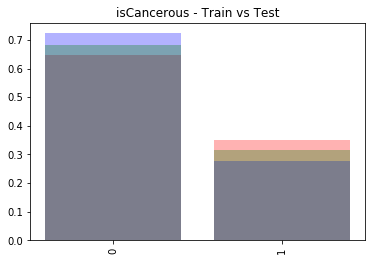

In [32]:
plt.bar(
    trainData.isCancerous.value_counts().index.astype(str), 
    trainData.isCancerous.value_counts().values/np.sum(trainData.isCancerous.value_counts().values), 
    alpha=0.3, 
    color='r')

plt.bar(
    valData.isCancerous.value_counts().index.astype(str), 
    valData.isCancerous.value_counts().values/np.sum(valData.isCancerous.value_counts().values), 
    alpha=0.3, 
    color='b')

plt.bar(
    testData.isCancerous.value_counts().index.astype(str), 
    testData.isCancerous.value_counts().values/np.sum(testData.isCancerous.value_counts().values), 
    alpha=0.3, 
    color='g')

plt.title('isCancerous - Train vs Test')
plt.xticks(rotation='vertical')

**Observations:**
1. Train/Validation/Test data distributions sets have similar distributions

# Images
27x27 RGB 

In [33]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Could add Data Augmentation here - but initial trials showed no real improvement for a lot of extra traing time
# Note: Sirinukunwattana 2016 and co arbitrary rotated patches (0, 90, 180, 270) and flipped them along vertical or 
# horizontal axis.
train_datagen = ImageDataGenerator(
    rescale=1./255, 
    data_format='channels_last',
    #rotation_range=90, 
    #width_shift_range=0.1,
    #height_shift_range=0.1, 
    #brightness_range=[0.5,1.5],
    #horizontal_flip=True,
    #vertical_flip=True
)
    
val_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')

batch_size = 32

train_generator = train_datagen.flow_from_dataframe(
        dataframe=trainData,
        directory='./patch_images',
        x_col="ImageName",
        y_col="isCancerous",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='categorical')

validation_generator = val_datagen.flow_from_dataframe(
        dataframe=valData,
        directory='patch_images',
        x_col="ImageName",
        y_col="isCancerous",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='categorical')

test_generator = val_datagen.flow_from_dataframe(
        dataframe=testData,
        directory='patch_images',
        x_col="ImageName",
        y_col="isCancerous",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='categorical')

Found 1495 validated image filenames belonging to 2 classes.
Found 303 validated image filenames belonging to 2 classes.
Found 202 validated image filenames belonging to 2 classes.


### Utility Functions

In [34]:
import seaborn as sn
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report


In [35]:
def PlotModelFitHistory(mh):
    plt.figure(figsize=(10,5))
    plt.subplot(1,2,1)
    plt.plot(mh.history['loss'], 'r--')
    plt.plot(mh.history['val_loss'], 'b--')
    plt.xlabel("epochs")
    plt.ylabel("Loss")
    plt.legend(['train', 'val'], loc='upper left')

    plt.subplot(1,2,2)
    plt.plot(mh.history['categorical_accuracy'], 'r--')
    plt.plot(mh.history['val_categorical_accuracy'], 'b--')
    plt.xlabel("epochs")
    plt.ylabel("Accuracy")
    plt.legend(['train', 'val'], loc='upper left')

    plt.show()


In [36]:
def PlotConfusionMatrix(test, pred):
    cm = confusion_matrix(test, pred)
    group_names = ['True Neg','False Pos','False Neg','True Pos']
    group_counts = ["{0:0.0f}".format(value) for value in cm.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in cm.flatten()/np.sum(cm)]
    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names, group_counts, group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    sn.heatmap(cm, annot=labels, fmt='', cmap='Blues')

# Model Development

### Measure 
As this is a screening/detection task, the impact of a false negative is high (ie someone who has cancer is missed)
In this case use Recall for measure.
We can also use F1 to get a more balanced measure of Precision and Recall

In [44]:
def CompileModel(model):
    opt = tf.keras.optimizers.Adagrad()
    model.compile(optimizer=opt,
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
              metrics=['categorical_accuracy'])    

In [54]:
# using patience here - could use other limits
early_stopping_patience=10
early_stopping_monitor = EarlyStopping(patience=early_stopping_patience, monitor='val_categorical_accuracy')

def FitModel(model):

    print('start ', datetime.datetime.now().strftime("%H:%M:%S"))
    now = datetime.datetime.now()

    fit_history = model.fit(train_generator, validation_data = validation_generator, 
                            callbacks=[early_stopping_monitor], epochs=10000, verbose=1)

    print('stop ', datetime.datetime.now().strftime("%H:%M:%S"))
    print("Took = ", datetime.datetime.now() - now)
    
    return fit_history

In [46]:
def PredictModel(model):
    batch_size_ = 1
    y_pred = list()
    y_test = list()
    filenames = test_generator.filenames
    N_images = len(filenames)
    batches = 0

    # iterate through the data generator and predict for each batch
    # hold the predictions and labels
    for x,y in test_generator:
            yp = model.predict(x, verbose=0)
            yp = np.argmax(yp, axis = 1)
            yt = np.argmax(y, axis = 1)
            y_pred = y_pred + yp.tolist()
            y_test = y_test + yt.tolist()

            batches += 1
            if batches >= N_images / batch_size_:
                break
                
    return (y_test, y_pred)

In [117]:
class ModelResult:
  def __init__(self, name, accuracy, f1, precision, recall):
    self.name = name
    self.accuracy = accuracy
    self.f1 = f1
    self.precision = precision
    self.recall = recall
    
modelResults = list()

In [118]:
def ShowStats(test_name, y_test, y_pred):
    accuracy = accuracy_score(test_y, pred_y)
    f1 = f1_score(test_y, pred_y, average='macro')
    cm = classification_report(test_y, pred_y, zero_division=0)
    
    prfs = precision_recall_fscore_support(test_y, pred_y, zero_division=0)
    detect_precision = prfs[0][1]
    detect_recall = prfs[1][1]

    mr = ModelResult(test_name, accuracy, f1, detect_precision, detect_recall)
    modelResults.append(mr)

    print("Accuracy score: ", accuracy_score(test_y, pred_y))
    print("F1 score: ", f1_score(test_y, pred_y, average='macro'))
    print(classification_report(test_y, pred_y, zero_division=0))

### Model Inputs

In [40]:
INPUT_DIM = (27,27,3)
OUTPUT_CLASSES = 2       # TensorFlow automatically does one hot encoding to our target label

## 1. Baseline an simple MLP Model
Observations
* Use a initial NN to get a baseline
* Binary classification problem
* Input has 2187 dims (this is small for image recognition)
* 1 hidden layer with 256 internal nodes
* 1 output binary
* Loss - Binary Cross Entropy
* Metric - binary_accuracy 
* use sigmoid activation as this is a logistics issue



In [ ]:
model_base = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=INPUT_DIM),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(OUTPUT_CLASSES, activation='sigmoid')
])

In [ ]:
model_base.summary()

In [ ]:
CompileModel(model_base)

In [ ]:
history_base = FitModel(model_base)

In [ ]:
PlotModelFitHistory(history_base)

In [ ]:
(test_y, pred_y) = PredictModel(model_base)

In [ ]:
ShowStats(test_y, pred_y)

In [ ]:
PlotConfusionMatrix(test_y, pred_y)

### Observation
* Train vs Validation approaches at 150 epocs
* There is significant overfitting of model after a short number of epochs
* Results show no detection of cancorous images - not usable
* Instability in accuracy could indicate too high learning rate


## 2. Base Model with regularisation
To reduce overfitting try regularisation

In [ ]:
# Use default lambda - note for assignment only. In real this might be in loop to determine best value.
reg_lambda = 0.01

model_reg = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=INPUT_DIM),
    tf.keras.layers.Dense(256, activation='sigmoid', kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.Dense(OUTPUT_CLASSES, activation='sigmoid', kernel_regularizer=tf.keras.regularizers.l2(reg_lambda))
])

In [ ]:
model_reg.summary()

In [ ]:
CompileModel(model_reg)

In [ ]:
history_reg = FitModel(model_reg)

In [ ]:
PlotModelFitHistory(history_reg)

In [ ]:
(test_y, pred_y) = PredictModel(model_reg)

In [ ]:
ShowStats(test_y, pred_y)

In [ ]:
PlotConfusionMatrix(test_y, pred_y)

### Observation
* Loss vs Epochs plot shows significantly improved fitting
* Accuracy stablises at ~ 80% after 20 epochs
* Learning rate maybe still high but results good
* Model doesn't detect positive cases

## 3. Base Model with dropout
To reduce overfitting and improve speed see if minor drop out improves the model.

In [50]:
model_drop = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=INPUT_DIM),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(.2),
    tf.keras.layers.Dense(OUTPUT_CLASSES, activation='sigmoid')
])

In [51]:
model_drop.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 2187)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               560128    
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 514       
Total params: 560,642
Trainable params: 560,642
Non-trainable params: 0
_________________________________________________________________


In [52]:
CompileModel(model_drop)

In [53]:
history_drop = FitModel(model_drop)

start  10:32:30
Epoch 1/10000
47/47 [==============================] - 2s 30ms/step - loss: 0.8305 - categorical_accuracy: 0.5662 - val_loss: 0.5316 - val_categorical_accuracy: 0.7888
Epoch 2/10000
47/47 [==============================] - 1s 18ms/step - loss: 0.5988 - categorical_accuracy: 0.6928 - val_loss: 0.4656 - val_categorical_accuracy: 0.7591
Epoch 3/10000
47/47 [==============================] - 1s 18ms/step - loss: 0.5516 - categorical_accuracy: 0.7328 - val_loss: 0.4481 - val_categorical_accuracy: 0.8152
Epoch 4/10000
47/47 [==============================] - 1s 21ms/step - loss: 0.5319 - categorical_accuracy: 0.7436 - val_loss: 0.4289 - val_categorical_accuracy: 0.7822
Epoch 5/10000
47/47 [==============================] - 1s 18ms/step - loss: 0.5312 - categorical_accuracy: 0.7320 - val_loss: 0.4382 - val_categorical_accuracy: 0.8416
Epoch 6/10000
47/47 [==============================] - 1s 18ms/step - loss: 0.5017 - categorical_accuracy: 0.7482 - val_loss: 0.4149 - val_categ

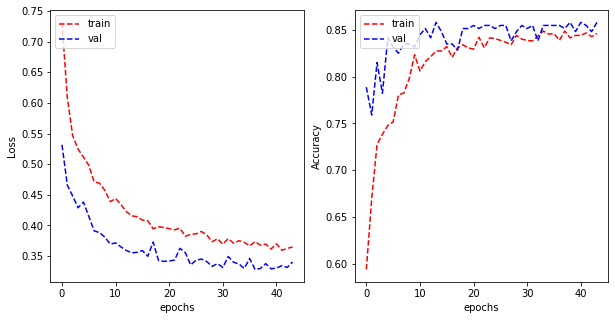

In [55]:
PlotModelFitHistory(history_drop)

In [56]:
(test_y, pred_y) = PredictModel(model_drop)

In [57]:
ShowStats(test_y, pred_y)

Accuracy score:  0.9009917920656635
F1 score:  0.8836991546254993
              precision    recall  f1-score   support

           0       0.92      0.94      0.93      3994
           1       0.87      0.81      0.84      1854

    accuracy                           0.90      5848
   macro avg       0.89      0.88      0.88      5848
weighted avg       0.90      0.90      0.90      5848



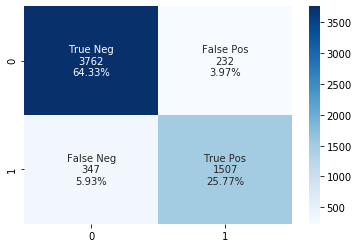

In [58]:
PlotConfusionMatrix(test_y, pred_y)

## Observation
* Dropout also improves but test data looks to be better than training
* This may be result of the data but there also looks to be some overfitting
* This doesn't appear to improve on model 2

## 4. Baseline Plus VGG
Using an initial set of convolution layers may improve input to the MLP layers
Use standard VGG architecture to check if this provides better results

In [ ]:
model_VGG_1 = tf.keras.Sequential([
    #VGG block 1
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=INPUT_DIM),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    #VGG block 2
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    #VGG block 3
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    tf.keras.layers.Flatten(),
    
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(.2),
    tf.keras.layers.Dense(OUTPUT_CLASSES, activation='sigmoid' )
])

In [ ]:
CompileModel(model_VGG_1)

In [ ]:
history_VGG_1 = FitModel(model_VGG_1)

In [ ]:
PlotModelFitHistory(history_VGG_1)

In [ ]:
(test_y, pred_y) = PredictModel(model_VGG_1)

In [ ]:
ShowStats(test_y, pred_y)

In [ ]:
PlotConfusionMatrix(test_y, pred_y)

### Observation
Issue is over fitting 
* This model took much longer to train.
* Reviewing the input size that VGG was designed for the number of inputs is much reduced.
* Lets reduce the number of convolutions layers and converlutions in the layer to improve training times.

## 5. VGG 2 with simplified convolutions
* We have 20k images so that should be ok for training
* image size is small so down scaling is not too beneficial
* after 40 epics so could stop early 
* over fitting so reduce the number of convolutions
* Given number of images, data augmentation probably not required


In [ ]:
model_VGG_2 = tf.keras.Sequential([
    #VGG block 1
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=INPUT_DIM),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    #VGG block 2
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    tf.keras.layers.Flatten(),
    
    tf.keras.layers.Dense(128, activation='sigmoid'),
    tf.keras.layers.Dropout(.2),
    tf.keras.layers.Dense(OUTPUT_CLASSES, activation='sigmoid' )
])

In [ ]:
CompileModel(model_VGG_2)

In [ ]:
history_VGG_2 = FitModel(model_VGG_2)

In [ ]:
PlotModelFitHistory(history_VGG_2)

In [ ]:
(test_y, pred_y) = PredictModel(model_VGG_2)

In [ ]:
ShowStats(test_y, pred_y)

In [ ]:
PlotConfusionMatrix(test_y, pred_y)

### Observations
* The model still took a long time to train
* There looks to be minimal overfitting
* Reducing the number of epochs to 50 showed minimal loss issues but accuracy was jumbled

## 6. SC-CNN 
* Try model based on SC-CNN 
* We have 20k images so that should be ok for training

In [ ]:
model_SC_CNN_1 = tf.keras.Sequential([
    # Convolution
    
    tf.keras.layers.Conv2D(24, (4, 4), activation='relu', padding='same', input_shape=INPUT_DIM),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(36, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    tf.keras.layers.Flatten(),
    
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(OUTPUT_CLASSES, activation='sigmoid' )
    
])

In [ ]:
CompileModel(model_SC_CNN_1)

In [ ]:
history_SC_CNN_1 = FitModel(model_SC_CNN_1)

In [ ]:
PlotModelFitHistory(history_SC_CNN_1)

In [ ]:
(test_y, pred_y) = PredictModel(model_SC_CNN_1)

In [ ]:
ShowStats(test_y, pred_y)

In [ ]:
PlotConfusionMatrix(test_y, pred_y)

### Observations
* The model overfitted significantly
* Accuracy not correct

# 7. SC-CNN 2

In [ ]:
model_SC_CNN_2 = tf.keras.Sequential([
    # Convolution
    
    tf.keras.layers.Conv2D(24, (4, 4), activation='relu', padding='same', input_shape=INPUT_DIM),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(36, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    tf.keras.layers.Flatten(),
    
    tf.keras.layers.Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
      
    tf.keras.layers.Dropout(.2),
    
    tf.keras.layers.Dense(
        OUTPUT_CLASSES, 
        kernel_regularizer=tf.keras.regularizers.l2(reg_lambda),
        activation='sigmoid' )
    
])

Still didn't pickup anything

# 8. SC-CNN 3

In [ ]:
model_SC_CNN_3 = tf.keras.Sequential([
    # Convolution
    
    tf.keras.layers.Conv2D(24, (4, 4), activation='relu', padding='same', input_shape=INPUT_DIM),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(36, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    tf.keras.layers.Flatten(),
    
    tf.keras.layers.Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
        
    tf.keras.layers.Dense(
        OUTPUT_CLASSES, 
        kernel_regularizer=tf.keras.regularizers.l2(reg_lambda),
        activation='sigmoid' )
    
])

# Model comparison and ultimate judgment

In [116]:
#Print out Summary Results
print("{:20} {:>10} {:>10} {:>10} {:>10}".format('Name', 'Accuracy', 'F1-score', 'Precision', 'Recall'))
for mr in modelResults:
    print("{:20} {:10.2f} {:10.2f} {:10.2f} {:10.2f}".format(mr.name, mr.accuracy, mr.f1, mr.precision, mr.recall))

Name                   Accuracy   F1-score  Precision     Recall
test                       0.90       0.88       0.87       0.81
test                       0.90       0.88       0.87       0.81
test                       0.90       0.88       0.87       0.81
one                        0.90       0.88       0.87       0.81
one fewfew fewfew          0.90       0.88       0.87       0.81
one fewfew fewfew          0.90       0.88       0.87       0.81


The base MLP model show overfitting
Using Regularistion resulted in a better model
Applying dropout also reduced overfitting but not the the same extent as regularisation 

Using the base VGG achitecture resulted in a small amount of overfitting
As the size of the inputs are quite low reducing the number of convolutions and adding some regulariation in the final MLP 
latyer might create a better model. 

All base models showed good results with 100% recall
Given the training time and simplicity the MLP with regularisation would be the best model

# Questions
* Results are the same for all models - looks bad but I can work out why
* accuracy jumps around but how to set learning rate?